In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# === Drink Dataset 建立 ===
np.random.seed(42)

drink_data = [
    {"Class": "A", "Drink": "Coke", "Rank": 8, "Amount_mean": 100, "Amount_std": 200, "Quantity_low": 500, "Quantity_high": 1000, "Count": 100},
    {"Class": "B", "Drink": "Pepsi", "Rank": 7, "Amount_mean": 200, "Amount_std": 10, "Quantity_low": 500, "Quantity_high": 1000, "Count": 200},
    {"Class": "C", "Drink": "Sprite", "Rank": 6, "Amount_mean": 200, "Amount_std": 10, "Quantity_low": 500, "Quantity_high": 1000, "Count": 100},
    {"Class": "D", "Drink": "7Up", "Rank": 5, "Amount_mean": 400, "Amount_std": 100, "Quantity_low": 500, "Quantity_high": 1000, "Count": 400},
    {"Class": "E", "Drink": "Cappuccino", "Rank": 4, "Amount_mean": 700, "Amount_std": 10, "Quantity_low": 1, "Quantity_high": 500, "Count": 400},
    {"Class": "F", "Drink": "Espresso", "Rank": 3, "Amount_mean": 700, "Amount_std": 10, "Quantity_low": 1, "Quantity_high": 500, "Count": 200},
    {"Class": "G", "Drink": "Latte", "Rank": 2, "Amount_mean": 800, "Amount_std": 300, "Quantity_low": 1, "Quantity_high": 500, "Count": 100},
    {"Class": "H", "Drink": "Mocha", "Rank": 1, "Amount_mean": 900, "Amount_std": 400, "Quantity_low": 1, "Quantity_high": 500, "Count": 100},
]

records = []
for entry in drink_data:
    count = entry["Count"]
    records.append(pd.DataFrame({
        "Class": entry["Class"],
        "Drink": entry["Drink"],
        "Rank": entry["Rank"],
        "Amount": np.random.normal(entry["Amount_mean"], entry["Amount_std"], size=count),
        "Quantity": np.random.randint(entry["Quantity_low"], entry["Quantity_high"] + 1, size=count),
    }))
df = pd.concat(records, ignore_index=True)


In [2]:
# === 每類別最多取 30 筆 ===
df_sampled = (
    df.groupby("Class", group_keys=False)
    .apply(lambda x: x.sample(n=min(30, len(x)), random_state=42))
    .reset_index(drop=True)
)

# === 正規化數值欄位 ===
scaler = MinMaxScaler()
df_sampled[['Rank', 'Amount', 'Quantity']] = scaler.fit_transform(df_sampled[['Rank', 'Amount', 'Quantity']])

# === One-hot Encoding ===
try:
    onehot = OneHotEncoder(sparse_output=False)  # sklearn ≥ 1.2
except:
    onehot = OneHotEncoder(sparse=False)         # sklearn < 1.2

drink_onehot = onehot.fit_transform(df_sampled[['Drink']])
df_onehot = pd.DataFrame(drink_onehot, columns=onehot.get_feature_names_out(['Drink']))
X_onehot = pd.concat([df_sampled[['Rank', 'Amount', 'Quantity']].reset_index(drop=True), df_onehot], axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_75040\3945405590.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(30, len(x)), random_state=42))


C:\Users\User\anaconda3\envs\tf_gpu_210\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\User\anaconda3\envs\tf_gpu_210\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


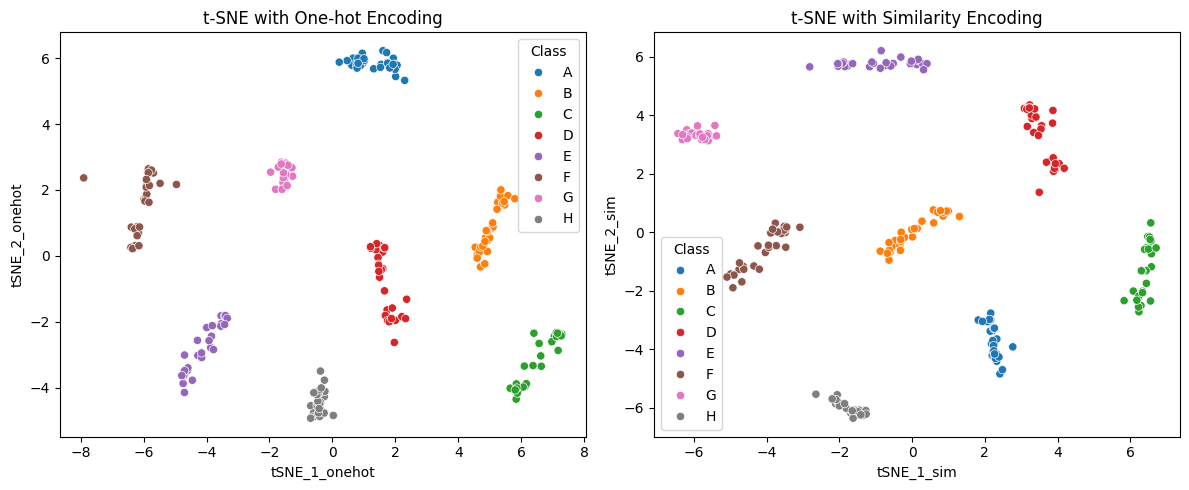

In [3]:
# === Similarity encoding ===
carbonated = ['Coke', 'Pepsi', 'Sprite', '7Up']
coffee = ['Cappuccino', 'Espresso', 'Latte', 'Mocha']
all_drinks = df_sampled['Drink'].unique()

sim_matrix = pd.DataFrame(0, index=all_drinks, columns=all_drinks, dtype=float)
for d1 in all_drinks:
    for d2 in all_drinks:
        if d1 == d2:
            sim_matrix.loc[d1, d2] = 0
        elif (d1 in carbonated and d2 in carbonated) or (d1 in coffee and d2 in coffee):
            sim_matrix.loc[d1, d2] = 2
        else:
            sim_matrix.loc[d1, d2] = 4

drink_sim_vector = df_sampled['Drink'].apply(lambda d: sim_matrix.loc[d].values)
df_sim = pd.DataFrame(drink_sim_vector.tolist(), columns=[f'Sim_{i}' for i in range(len(all_drinks))])
X_sim = pd.concat([df_sampled[['Rank', 'Amount', 'Quantity']].reset_index(drop=True), df_sim], axis=1)

# === t-SNE 計算 ===
tsne = lambda X: TSNE(n_components=2, perplexity=5, n_iter=250, init='pca', learning_rate='auto', random_state=42).fit_transform(X)
tsne_onehot = tsne(X_onehot)
tsne_sim = tsne(X_sim)

# === 加回 DataFrame
df_sampled['tSNE_1_onehot'] = tsne_onehot[:, 0]
df_sampled['tSNE_2_onehot'] = tsne_onehot[:, 1]
df_sampled['tSNE_1_sim'] = tsne_sim[:, 0]
df_sampled['tSNE_2_sim'] = tsne_sim[:, 1]

# === 畫圖比較
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='tSNE_1_onehot', y='tSNE_2_onehot', hue='Class', data=df_sampled, palette='tab10')
plt.title('t-SNE with One-hot Encoding')

plt.subplot(1, 2, 2)
sns.scatterplot(x='tSNE_1_sim', y='tSNE_2_sim', hue='Class', data=df_sampled, palette='tab10')
plt.title('t-SNE with Similarity Encoding')

plt.tight_layout()
plt.show()